In [1]:
import pennylane as qml
from qiskit_quantuminspire.qi_provider import QIProvider
from pennylane_quantuminspire.qi_device import QIDevice
from pennylane.qinfo import fidelity
import pennylane.numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal as mn

In [2]:
def my_biclass_gm(mu1, Sigma1, mu2, Sigma2, scale=1.0, N1=100, N2=100):
    np.random.seed(0)
    Sigma1 = np.array(Sigma1) * scale
    Sigma2 = np.array(Sigma2) * scale

    pdf1 = mn(mu1, Sigma1)
    pdf2 = mn(mu2, Sigma2)

    X = np.r_[pdf1.rvs(size=N1), pdf2.rvs(size=N2)]
    y = np.array([0]*N1 + [1]*N2, dtype=int)  

    return X, y

def graficar_datos_2d(x, y, title="Datos 2D"):
    """
    Visualiza datos 2D con dos clases (0 y 1) usando colores distintos.
    """
    cmap = ListedColormap(['#FF5555', '#55FF55']) 
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, edgecolor='k')
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.grid(True)
    
    
    plt.show()
    

In [3]:
mu1 = np.array([-3,-2])
mu2 = np.array([0,2])
Sigma1 = np.array([[2,0.8],[0.8,1]])
Sigma2 = np.array([[1.5,0.6],[0.6,3]])

In [5]:
provider = QIProvider()
backend = provider.get_backend('Tuna-5')
demo_device = QIDevice(backend)
dev = demo_device

In [7]:
def codificar(x, params):
    return params[0]*x[0] + params[1]*x[1] + params[2]

@qml.qnode(dev)
def dru_circuit(x_comb, p1, p2, p3):
    qml.RX(x_comb, wires=0)
    qml.RY(p1 * x_comb + p2, wires=0)
    qml.RZ(p3, wires=0)
    return qml.probs(wires=0)
def circuito_wrapper(params, x):
    x_comb = codificar(x, params)
    return dru_circuit(x_comb, params[3], params[4], params[5])

In [8]:
def graficar_frontera_cuantica(params, x, y, funcion_circuito, h=0.05, title="Frontera de decisión (cuántica)"):
    """
    Dibuja la frontera de decisión del clasificador cuántico.
    """
    from matplotlib.colors import ListedColormap
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # definir rejilla sobre espacio 2D
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # predicción cuántica para cada punto del mesh
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = list()
    for punto in grid_points:
        Z.append(np.argmax(funcion_circuito(params, punto)))
        print(punto)
    Z = np.array(Z).reshape(xx.shape)

    # fondo coloreado según clase predicha
    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # puntos de entrenamiento originales
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.grid(True)
    plt.show()


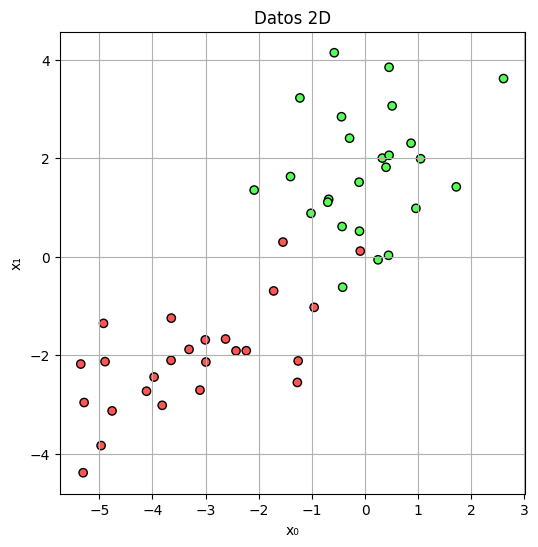

In [10]:
x, y =  my_biclass_gm(mu1,Sigma1,mu2,Sigma2, scale =  0.8, N1=25, N2=25)

graficar_datos_2d(x,y)


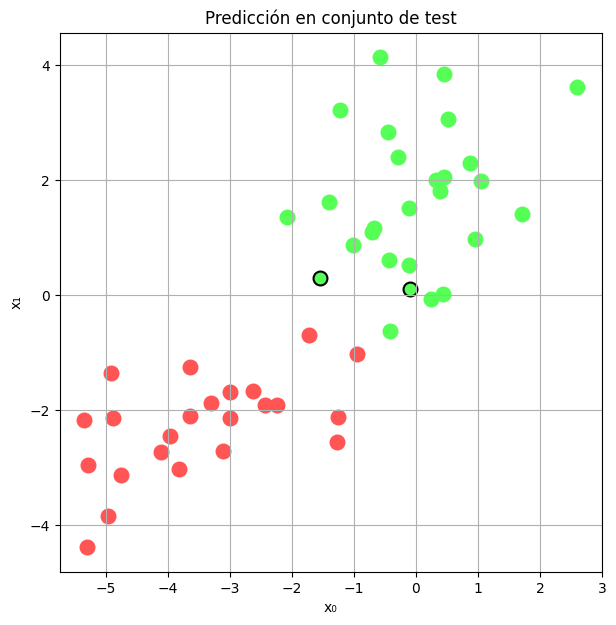

Exactitud (Tuna-5 sobre test): 96.00%


In [11]:
def evaluar_solo_test(params, x_test, funcion_circuito):
    """
    Evalúa el circuito cuántico solo sobre los puntos de test, no sobre una malla completa.
    """
    return [np.argmax(funcion_circuito(params, x)) for x in x_test]



def graficar_prediccion_test(x_test, y_test, y_pred, title="Predicción en conjunto de test"):
    """
    Grafica los puntos de test con sus clases reales y las clases predichas.
    Si real y predicción coinciden, el borde será del mismo color que el relleno.
    """
    cmap = ListedColormap(['#FF5555', '#55FF55'])  # Rojo y verde

    plt.figure(figsize=(7, 7))
    for i in range(len(x_test)):
        color = cmap(y_pred[i])
        borde = 'black' if y_pred[i] != y_test[i] else color
        plt.scatter(x_test[i, 0], x_test[i, 1],
                    c=[color], edgecolor=borde, s=100, marker='o', linewidth=1.5)

    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.grid(True)
    plt.show()

params = np.tensor([ 0.06368833,  0.06568811,  0.17939192,  5.02329452,  1.20879312, -0.23413696], requires_grad=True)

y_pred = evaluar_solo_test(params, x, circuito_wrapper)

graficar_prediccion_test(x, y, y_pred)

acc = np.mean(np.array(y_pred) == y)
print(f"Exactitud (Tuna-5 sobre test): {acc}")